In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.stats.multitest as multi

from CosinorPy import file_parser, cosinor, cosinor1
from CosinorPy.helpers import df_add_row
from RhythmCount import data_processing as dproc
from RhythmCount import plot

### Priprava podatkov

In [31]:
lj_dez = pd.read_csv("../nesrece_LjubljanaDez_dnevno_2010_2023.csv")

# Nastavljanje pravilnega časovnega pasu
lj_dez['NastanekDatumCas'] = pd.to_datetime(lj_dez['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_dez['NastanekDatumCas'] = lj_dez['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
print(f"NastanekDatumCas column dtype: {lj_dez['NastanekDatumCas'].dtype}")

NastanekDatumCas column dtype: datetime64[ns, Europe/Ljubljana]


## CosinorPy

Preverila bom, če se ritmičnost nesreč, ki so se zgodile v dežju, razlikuje od ritmičnosti nesreč, ki so se zgodile v lepem vremenu. Za nesreče v dežju bom upoštevala vse nesreče, ki so se zgodile na dan, ko je zapadlo vsaj 1,0 mm dežja.

In [32]:
# Maska za lepo vreme
sunny_mask = (lj_dez['rain_sum'] < 1.0)

lj_dez = lj_dez[sunny_mask]
# display(lj_dez)

# Za vsak vnos pridobi znotraj, katere ure se je zgodil
hours = lj_dez['NastanekDatumCas'].dt.hour

accidents_per_hour = hours.value_counts()

# Uredi podatke po vrstnem redu ur (naraščajoče)
accidents_per_hour = accidents_per_hour.sort_index()
# print(accidents_per_hour)

# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo CosinorPy
df_plot = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "x": accidents_per_hour.index,  # Ura (od 0 do 23)
    "y": accidents_per_hour.values  # Število nesreč za tisto uro
})

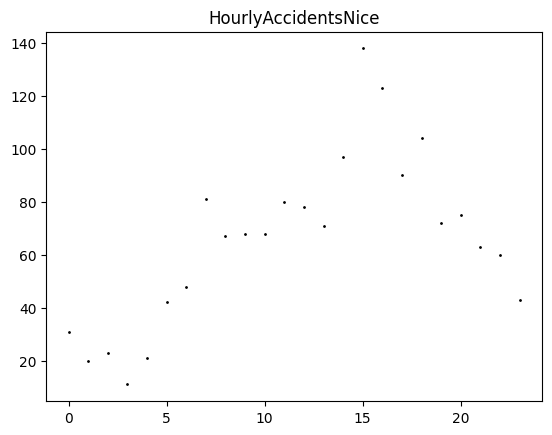

In [50]:
cosinor.plot_data(df_plot, names = ["HourlyAccidentsNice"])

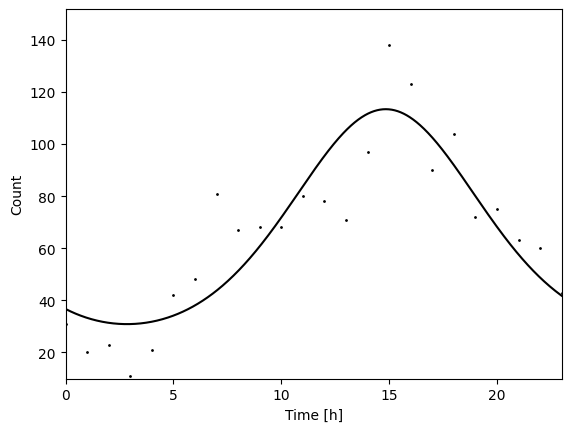

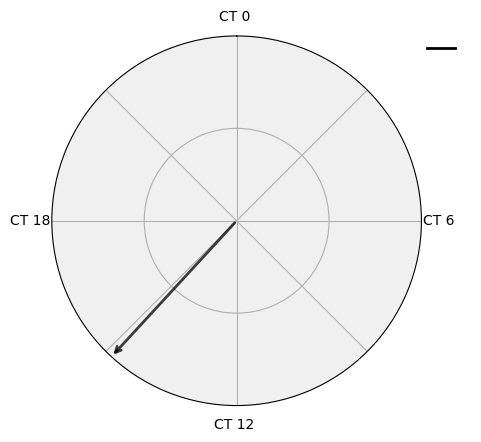

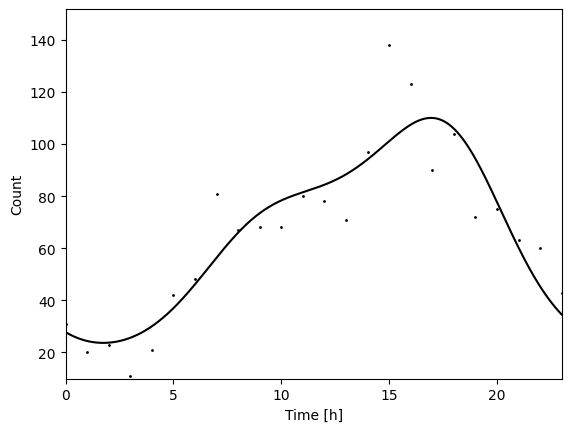

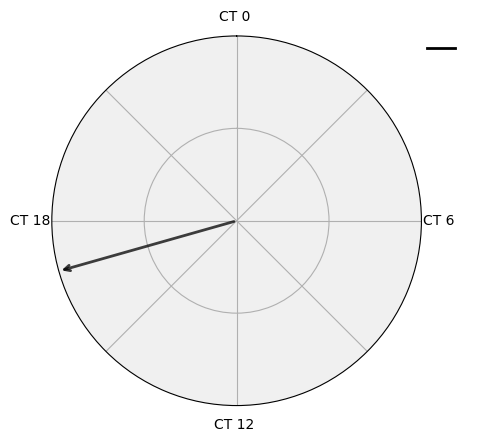

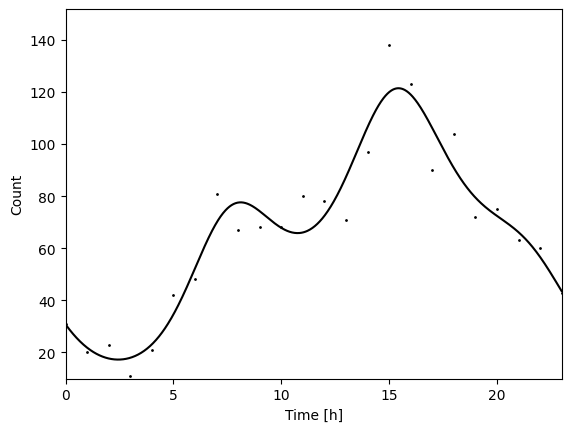

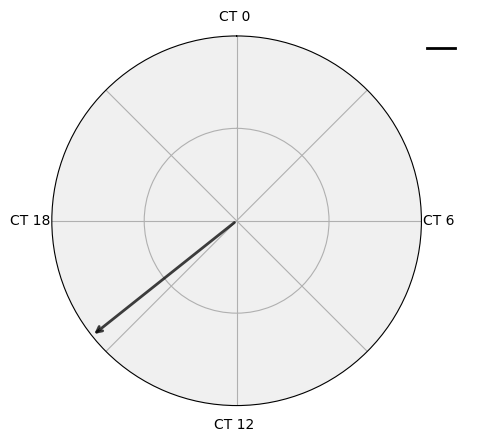

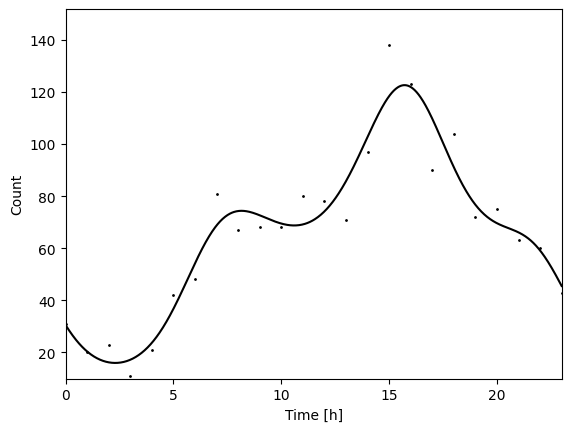

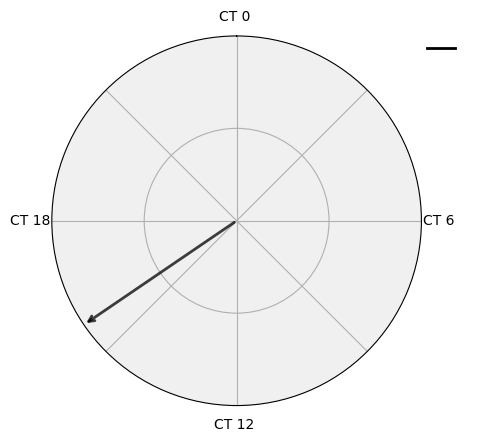

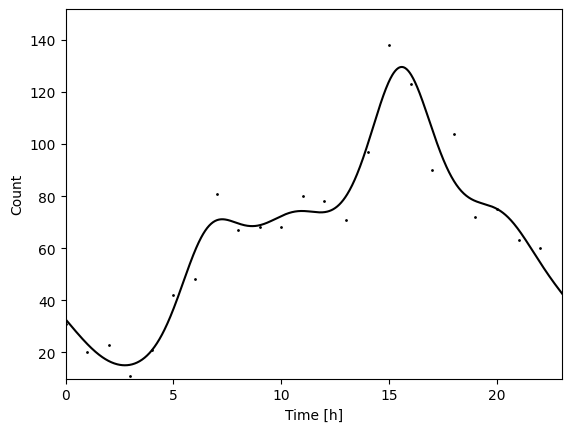

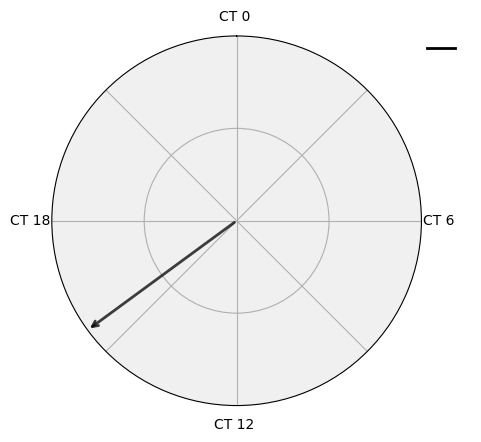

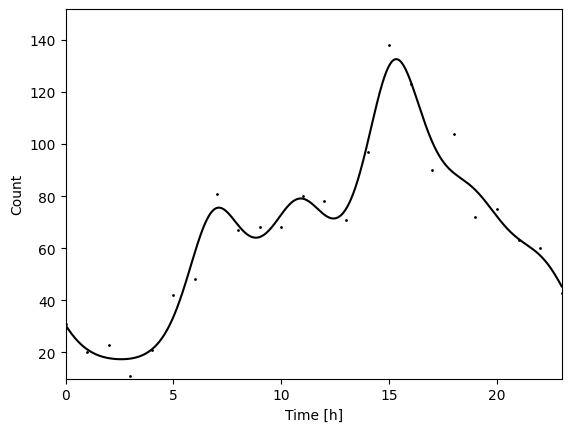

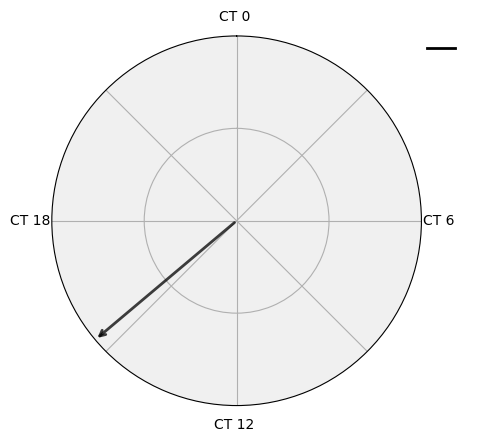

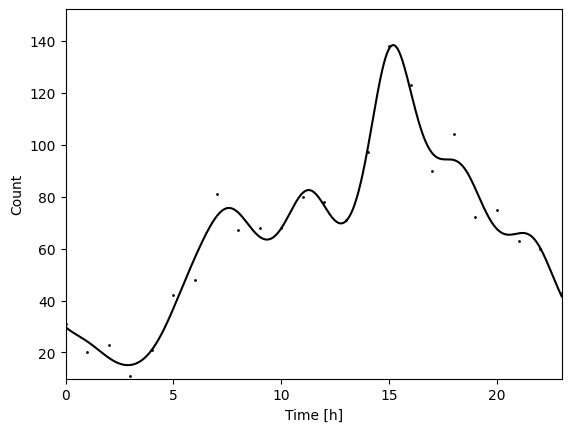

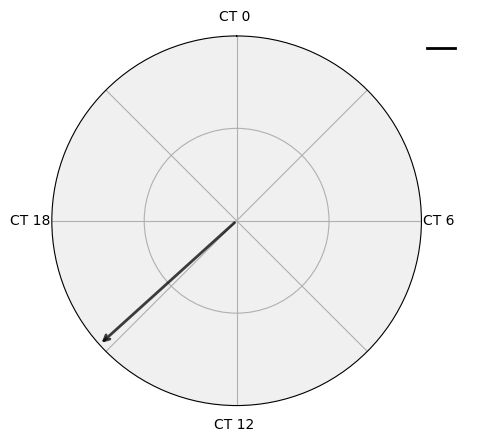

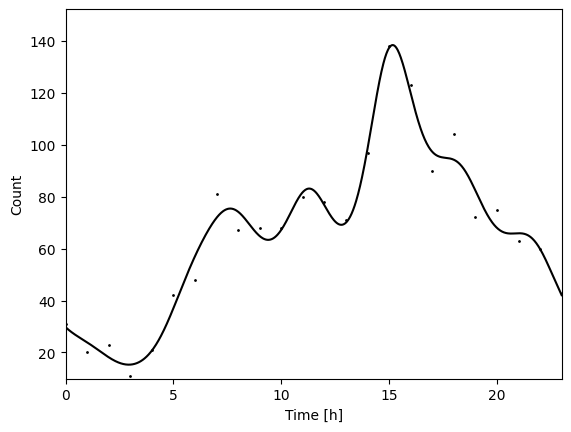

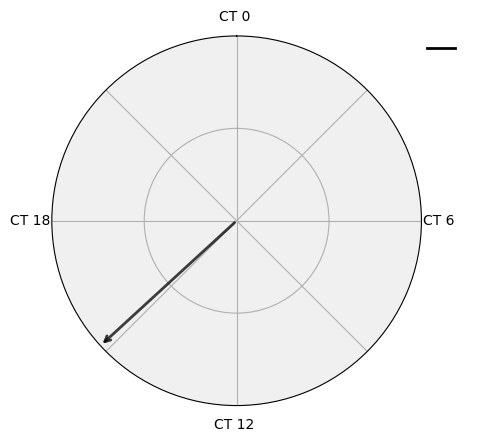

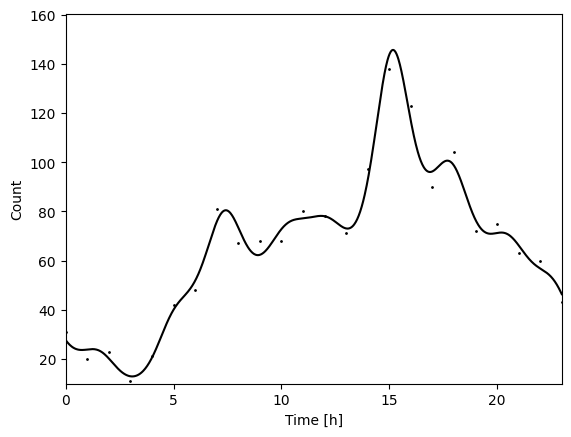

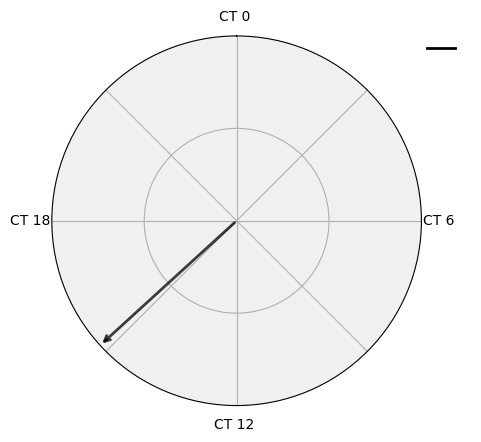

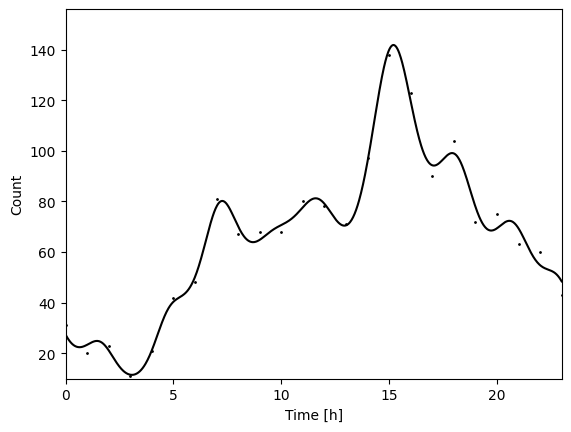

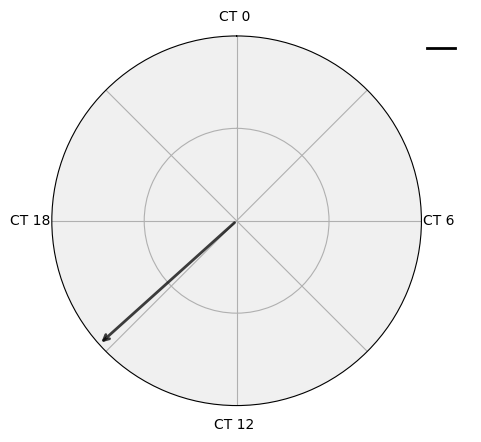

In [34]:
X = df_plot.x.to_numpy()
Y = df_plot.y.to_numpy()

df_results = pd.DataFrame(columns=[
    'test', 'period', 'n_components', 'p', 'q', 'RSS', 
    'log-likelihood', 'prsquared', 'amplitude', 'acrophase', 
    'mesor', 'peaks', 'heights', 'troughs', 'heights2'
], dtype=float)

all_models = []

numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for n_component in numbers:
    results, statistics, rhythm_param, _, _, model = cosinor.fit_me(X, Y, n_components = n_component, period = 24, model_type = 'gen_poisson', plot_margins=False, return_model=True)
    #result_table.append(result)

    # print("Statistics:", statistics.keys())
    # print("Rhythm parameters:", rhythm_param.keys())
    # print("Results attributes:", dir(results))
    # print(results.__dict__.keys())
    # print(results.summary())
    # print("AIC in BIC", results.aic, results.bic)
    # help(results)


    df_results = df_add_row(df_results, {
        'test': 'HourlyAccidentsNice', 
        'period': 24,
        'n_components': n_component,
        'p': statistics['p'], 
        'RSS': statistics['RSS'],
        'log-likelihood': results.llf,        
        'prsquared': results.prsquared,  # Alternative to R²
        'AIC': results.aic,
        'BIC': results.bic,
        'amplitude': rhythm_param['amplitude'],
        'acrophase': rhythm_param['acrophase'],
        'mesor': rhythm_param['mesor'],
        'peaks': rhythm_param['peaks'],
        'heights': rhythm_param['heights'],
        'troughs': rhythm_param['troughs'],
        'heights2': rhythm_param['heights2']
    })

    # Likelihood-ratio test
    if n_component == 1:
        DOF_simpler = 0
        n_params_simpler = 0
        n_component_simpler = 0
        results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = results, statistics, rhythm_param, model
        
    n_params = len(results.params)
    DOF = len(df_plot)-n_params
    llf = results.llf

    p_accept_llf = 0
    
    if DOF < DOF_simpler:
        p_accept_llf = cosinor.compare_models_LR_test(llf_simpler, llf, n_params_simpler, n_params)

    llf_simpler = llf
    DOF_simpler = DOF

    if p_accept_llf < 0.05:
        n_component_simpler, results_simpler, statistics_simpler, rhythm_param_simpler, model_simpler = n_component, results, statistics, rhythm_param, model

    all_models.append(['HourlyAccidentsNice', n_component, results, statistics, rhythm_param, model, p_accept_llf])

df_results.q = multi.multipletests(df_results.p, method = 'fdr_bh')[1]

# Dataframe za najboljši model na podlagi likelihood-ratio testa
df_best_model = pd.DataFrame([{
        'test': 'HourlyAccidentsNice',
        'period': 24,
        'n_components': n_component_simpler,
        'p': statistics_simpler['p'], 
        'RSS': statistics_simpler['RSS'],
        'log-likelihood': results_simpler.llf,        
        'prsquared': results_simpler.prsquared,  # Alternative to R²
        'AIC': results_simpler.aic,
        'BIC': results_simpler.bic,
        'amplitude': rhythm_param_simpler['amplitude'],
        'acrophase': rhythm_param_simpler['acrophase'],
        'mesor': rhythm_param_simpler['mesor'],
        'peaks': rhythm_param_simpler['peaks'],
        'heights': rhythm_param_simpler['heights'],
        'troughs': rhythm_param_simpler['troughs'],
        'heights2': rhythm_param_simpler['heights2']
    }])

In [35]:
display(df_results)

,test,period,n_components,p,q,RSS,log-likelihood,prsquared,amplitude,acrophase,mesor,peaks,heights,troughs,heights2,AIC,BIC
0,HourlyAccidentsNice,24.0,1.0,7.423655e-09,7.423655e-09,5703.062258,-99.445112,0.158412,41.259125,2.397275,72.123260,[14.843084308430845],[113.38238362211793],[2.846684668466847],[30.86413818110484],206.890224,211.602439
1,HourlyAccidentsNice,24.0,2.0,6.587740e-10,7.319711e-10,4259.176362,-93.789326,0.206276,43.188124,1.846813,66.847615,[16.945694569456947],[110.0357304637397],[1.7425742574257428],[23.65949819983417],199.578651,206.646974
2,HourlyAccidentsNice,24.0,3.0,5.588295e-13,1.397074e-12,1876.567601,-83.494564,0.293399,52.088866,2.242693,69.337587,"[8.112811281128113, 15.433543354335434]","[77.61404211161282, 121.42645257827066]","[2.4386438643864388, 10.753075307530754]","[17.24872128380407, 65.81082760520384]",182.989128,192.413558
3,HourlyAccidentsNice,24.0,4.0,3.206896e-12,4.008619e-12,1778.500780,-82.698367,0.300137,53.325335,2.168544,69.288030,"[8.156015601560156, 15.716771677167719]","[74.36485557643066, 122.61334332972702]","[2.2994299429942995, 10.594659465946595]","[15.962695018550749, 68.74258176546631]",185.396733,197.177271
4,HourlyAccidentsNice,24.0,5.0,2.497236e-12,4.008619e-12,1353.407828,-79.945310,0.323436,57.266514,2.203733,72.326728,"[10.954695469546955, 15.582358235823584]","[74.29675700028348, 129.593166124009]","[2.7458745874587462, 8.645664566456647]","[15.060215731418205, 68.48767652422208]",183.890621,198.027267
5,HourlyAccidentsNice,24.0,6.0,2.146093e-12,4.008619e-12,919.993691,-77.420081,0.344807,57.607970,2.270342,74.990469,"[7.104710471047105, 10.901890189018903, 15.327...","[75.58187278435463, 79.1042634088343, 132.5983...","[2.5730573057305732, 8.818481848184819, 12.418...","[17.382499088338747, 64.04675873802329, 71.414...",182.840162,199.332916
6,HourlyAccidentsNice,24.0,7.0,4.965119e-13,1.397074e-12,640.344211,-73.472783,0.378212,61.614655,2.305531,76.743430,"[11.271527152715272, 15.193519351935194, 17.71...","[82.5388051222786, 138.35794513617142, 94.3335...","[2.8850885088508855, 9.332133213321333, 12.764...","[15.12878665307264, 63.47515824956482, 69.6990...",178.945566,197.794427
7,HourlyAccidentsNice,24.0,8.0,3.070516e-12,4.008619e-12,645.350850,-73.405282,0.378783,61.536047,2.313072,76.849160,"[11.290729072907292, 15.164716471647166]","[83.12242867659329, 138.38520703580429]","[2.9282928292829284, 9.38973897389739, 12.7836...","[15.313113118298757, 63.368573414954874, 69.16...",182.810564,204.015533
8,HourlyAccidentsNice,24.0,9.0,7.116746e-14,3.558373e-13,416.808225,-66.821044,0.434505,66.374406,2.310558,79.238776,"[7.421542154215422, 15.174317431743175, 17.694...","[80.43502855537979, 145.61318244401352, 100.59...","[0.7440744074407442, 3.081908190819082, 8.9048...","[23.615538660217055, 12.864369548787826, 62.18...",173.642088,197.203164
9,HourlyAccidentsNice,24.0,10.0,3.424965e-14,3.424965e-13,302.292251,-63.826651,0.459846,65.190939,2.303018,76.616699,"[7.263126312631264, 11.593159315931594, 15.203...","[80.17348035899644, 81.21791310365127, 141.807...","[0.6432643264326433, 3.0723072307230725, 8.688...","[22.35654379602338, 11.425760684464063, 63.870...",171.653302,197.570486


### Katero je najboljše število komponent

In [36]:
# df_best_model = cosinor.get_best_models(df_plot, df_results, n_components = [1,2,3,4,5,6,7,8,9,10])
df_best_model

,test,period,n_components,p,RSS,log-likelihood,prsquared,AIC,BIC,amplitude,acrophase,mesor,peaks,heights,troughs,heights2
0,HourlyAccidentsNice,24,3,5.588295e-13,1876.567601,-83.494564,0.293399,182.989128,192.413558,52.088866,2.242693,69.337587,"[8.112811281128113, 15.433543354335434]","[77.61404211161282, 121.42645257827066]","[2.4386438643864388, 10.753075307530754]","[17.24872128380407, 65.81082760520384]"


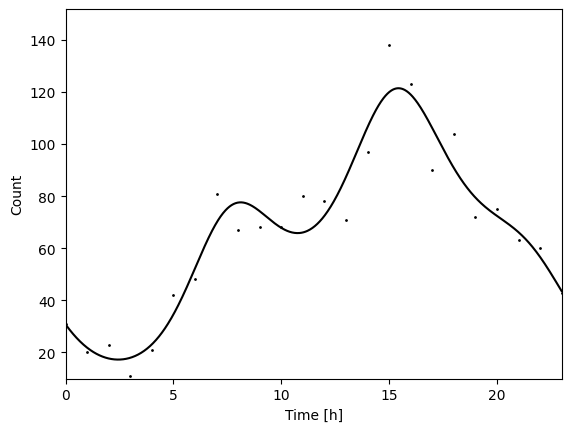

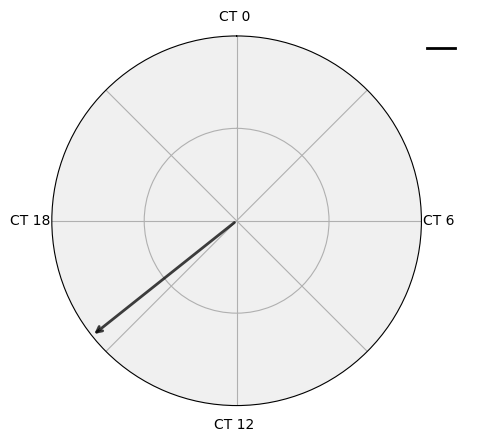

(<statsmodels.discrete.discrete_model.GeneralizedPoissonResultsWrapper at 0x232284463c0>,
 {'p': 5.588294809723288e-13, 'RSS': 1876.567600963, 'count': 1574},
 {'period': 24,
  'amplitude': 52.08886564723329,
  'acrophase': 2.242693105442939,
  'mesor': 69.33758693103736,
  'peaks': array([ 8.11281128, 15.43354335]),
  'heights': array([ 77.61404211, 121.42645258]),
  'troughs': array([ 2.43864386, 10.75307531]),
  'heights2': array([17.24872128, 65.81082761]),
  'max_loc': 3215,
  'period2': 24},
 array([0.00000000e+00, 4.80048005e-03, 9.60096010e-03, ...,
        4.79903990e+01, 4.79951995e+01, 4.80000000e+01]),
 array([30.69246635, 30.63858983, 30.5848111 , ..., 30.80051181,
        30.74644043, 30.69246635]))

In [48]:
#cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', save_to = "../PisanjeDiplome/angleskeSlike/kosinor-lepo-vreme", plot=True, plot_margins=False)
cosinor.fit_me(X, Y, n_components = 3, period = 24, model_type = 'gen_poisson', plot=True, plot_margins=False)

## RhythmCount

In [38]:
# Ustvari pandas dataframe v formatu, ki bo primeren za uporabo RhythmCount
df_plot_RC = pd.DataFrame({
    "test": "HourlyAccidentsNice",  # konstantna oznaka vseh vrstic
    "X": accidents_per_hour.index,  # Ura (od 0 do 23)
    "Y": accidents_per_hour.values  # Število nesreč za tisto uro
})

In [39]:
count_models = ['gen_poisson', 'nb']
n_components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Hana\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

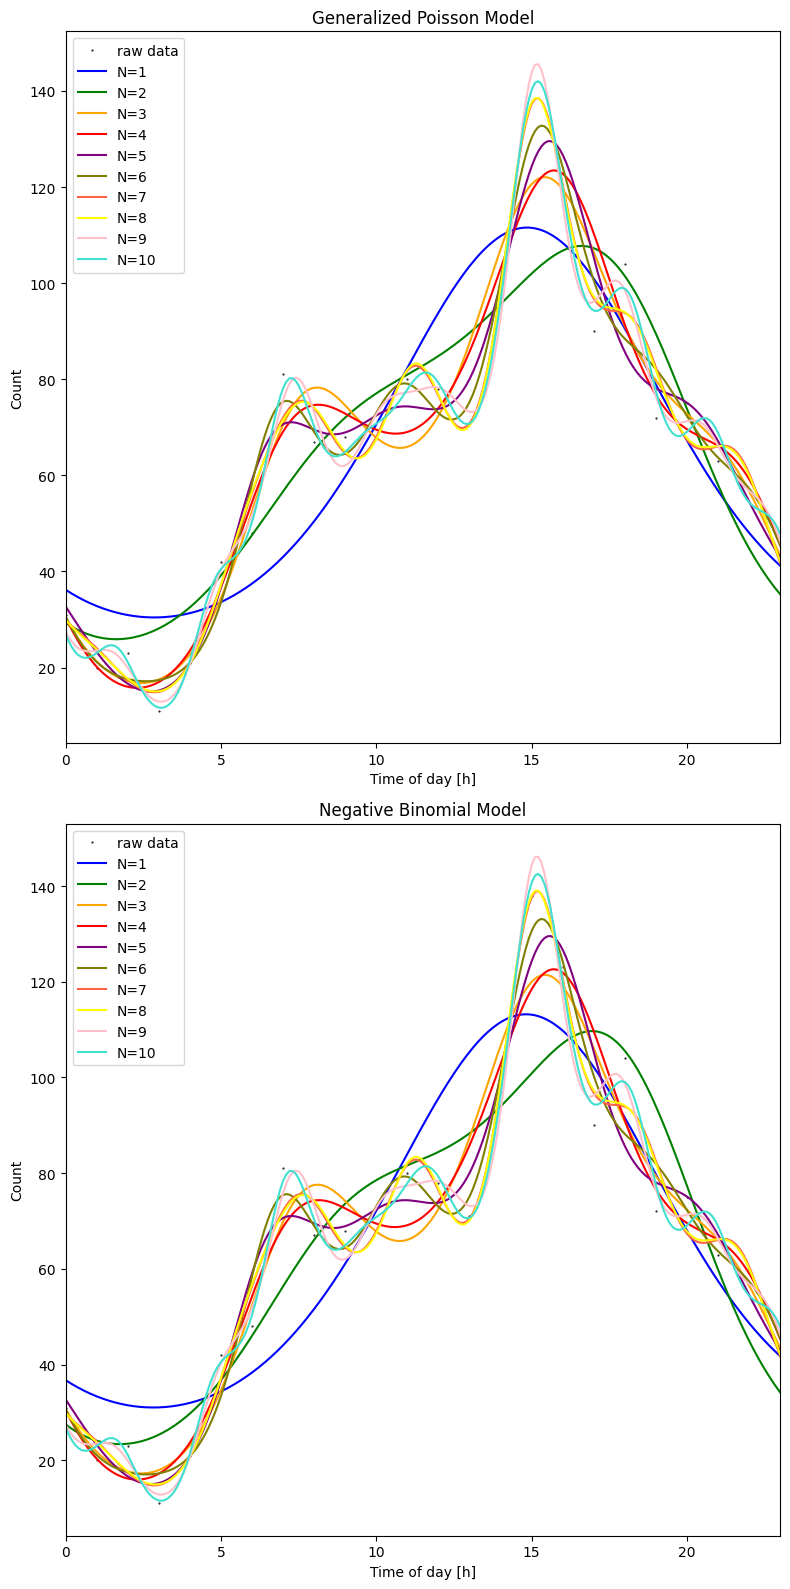

In [40]:
df_results_RC = dproc.fit_to_models(df_plot_RC, count_models, n_components, 24)

In [41]:
display(df_results_RC)

,count_model,n_components,amplitude,mesor,peaks,heights,llr_pvalue,RSS,AIC,BIC,log_likelihood,logs,mean(est),Y(est),X_test,Y_test
0,gen_poisson,1,40.56,71.00,[14.81],[111.56],7.924454e-09,5690.037094,207.020788,211.733003,-99.510394,"[-3.349983925108269, -3.757146374315962, -3.34...",64.581173,"[36.188421302209626, 32.80990343875448, 30.934...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[36.188421302209626, 35.77813095689392, 35.384..."
1,gen_poisson,2,40.91,66.83,[16.62],[107.74],1.587011e-09,4067.211085,201.410639,208.478962,-94.705319,"[-3.0299203968962907, -3.1395825295503705, -2....",65.431369,"[29.319056199675888, 26.39907295356132, 26.080...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[29.319056199675888, 28.898169049720515, 28.50..."
2,gen_poisson,3,52.63,69.43,[15.42],[122.06],8.779621e-13,1883.435434,183.946656,193.371086,-83.973328,"[-2.5595987795441495, -2.3864452993717187, -3....",65.704279,"[30.25033846285097, 21.294009944695276, 17.189...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[30.25033846285097, 29.134628134619618, 28.065..."
3,gen_poisson,4,53.84,69.62,[15.72],[123.46],4.241725e-12,1778.191152,186.006352,197.786891,-83.003176,"[-2.548499172986663, -2.327588208820245, -4.02...",65.710736,"[30.404230456169334, 20.176161207054502, 16.00...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[30.404230456169334, 29.099652398494772, 27.85..."
4,gen_poisson,5,57.26,72.29,[15.62],[129.55],2.502487e-12,1351.159277,183.895298,198.031944,-79.947649,"[-2.594976176924199, -2.6181850707545102, -3.7...",65.583333,"[32.70960977550655, 23.225519311887833, 16.643...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[32.70960977550655, 31.7144002656058, 30.72345..."
5,gen_poisson,6,57.81,74.97,[15.32],[132.78],2.653067e-12,920.797834,183.322040,199.814794,-77.661020,"[-2.5290703234269536, -2.356796210874421, -3.2...",65.583333,"[30.628352680105376, 21.161095781658123, 17.61...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[30.628352680105376, 29.357955265402342, 28.15..."
6,gen_poisson,7,61.82,76.69,[15.22],[138.51],1.707426e-12,638.349766,181.794940,200.643801,-74.897470,"[-2.546373517762241, -2.775471605472699, -3.33...",65.583333,"[29.94923577997396, 24.050272872441123, 17.522...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[29.94923577997396, 29.259988200163722, 28.622..."
7,gen_poisson,8,61.74,76.77,[15.22],[138.51],1.056206e-11,642.193426,185.734509,206.939478,-74.867254,"[-2.5455911377225746, -2.7188936045076986, -3....",65.583333,"[29.96905212365989, 23.77347362545073, 17.6992...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[29.96905212365989, 29.214061818540277, 28.514..."
8,gen_poisson,9,66.33,79.23,[15.22],[145.56],4.975428e-12,416.116351,183.757224,207.318301,-71.878612,"[-2.792417270673713, -2.6752813206757935, -2.6...",65.583333,"[27.43558038068805, 23.548464410633073, 19.953...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[27.43558038068805, 26.306304100235536, 25.379..."
9,gen_poisson,10,65.20,76.83,[15.22],[142.02],1.259691e-11,299.326008,185.949389,211.866573,-70.974694,"[-2.8834089140774957, -2.5840478973450907, -2....",65.583333,"[26.91197117135851, 23.035250008131424, 21.128...","[0.0, 0.1001001001001001, 0.2002002002002002, ...","[26.91197117135851, 25.44431062882791, 24.2453..."


## Kateri model je najboljši?

#### Najprej pogledamo, kateri model je najboljši, nato kolikšno število komponent je najboljše.

In [42]:
best_count_model = dproc.get_best_count_model(df_results_RC, 'Vuong')
print("Best model: {}".format(best_count_model.count_model))
best_model = dproc.get_best_n_components(df_results_RC, 'Vuong', count_model=best_count_model['count_model'])
print("Number of components: {}".format(best_model.n_components))

Best model: gen_poisson
Number of components: 3


#### Najprej pogledamo, kolikšno število komponent je najboljše, nato, kateri model je najboljši. 

In [43]:
best_n_components = dproc.get_best_n_components(df_results_RC, 'Vuong')
print("Number of components: {}".format(best_n_components.n_components))
best_model = dproc.get_best_count_model(df_results_RC, 'Vuong', n_components=best_n_components['n_components'])
print("Best model: {}".format(best_model.count_model))

Number of components: 3
Best model: gen_poisson


### Prikaz najboljšega modela skupaj z intervali zaupanja

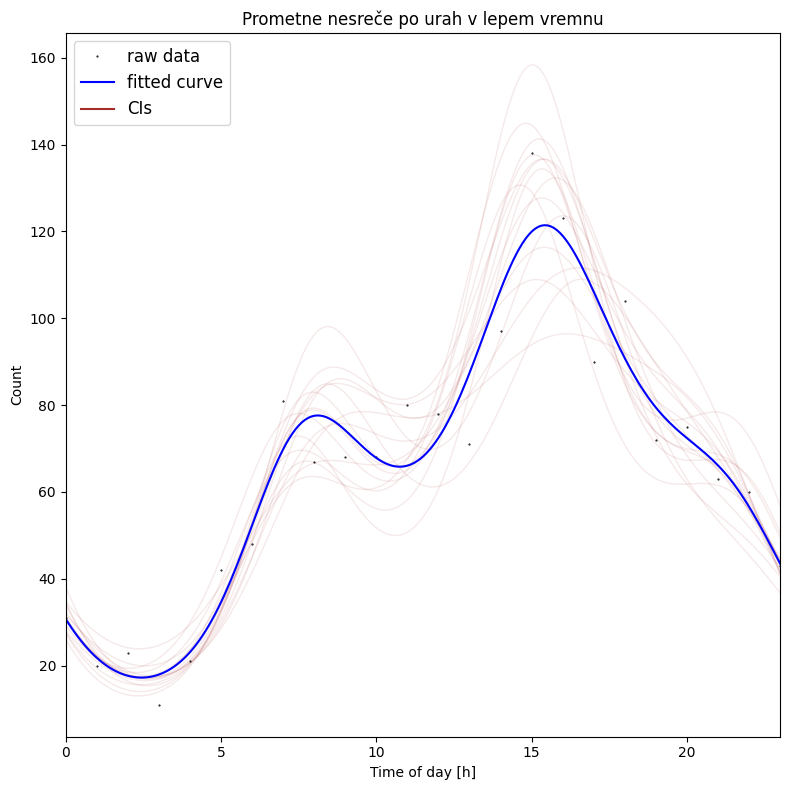

Intervali zaupanja:


,0,1
0,3.990689,4.102076
1,-0.549468,-0.353000
2,-0.670806,-0.476683
3,-0.308432,-0.106353
4,-0.260427,-0.114764
5,-0.267748,-0.086084
6,0.078702,0.210450
7,-0.277491,0.164896


In [44]:
# print(type(best_model))
# print(type(best_n_components))

# print(best_n_components)

count_model = best_model.count_model
n_components = int(best_n_components.n_components)

CIs = plot.plot_model(df_plot_RC, count_model, n_components, title='Prometne nesreče po urah v lepem vremnu', plot_CIs=True)
print('Intervali zaupanja:')
display(CIs)

### Parametri izbranega modela

In [45]:
CIs_params = dproc.calculate_confidence_intervals_parameters(df_plot_RC, n_components, count_model, best_model['peaks'])
best_model = pd.concat([best_model, pd.Series(CIs_params)], axis=0)
best_model=best_model[['count_model','n_components','amplitude', 'mesor', 'peaks', 'heights','amplitude_CIs','mesor_CIs','peaks_CIs','heights_CIs']]
print('Parametri modela in njihovi intervali zaupanja:')
display(best_model.to_frame())

Parametri modela in njihovi intervali zaupanja:


,0
count_model,gen_poisson
n_components,3
amplitude,52.63
mesor,69.43
peaks,[15.42]
heights,[122.06]
amplitude_CIs,"[45.4, 59.98]"
mesor_CIs,"[63.34, 76.77]"
peaks_CIs,"[14.73, 16.05]"
heights_CIs,"[109.4, 136.08]"
